Mixture density networks were introduced by Bishop in the 1994 paper [1]. In this post we will briefly explain what mixture density networks (MDNs) are and implement the examples in that paper. For detailed explanations and derivations, please see the paper (it's great for understanding some of the theory behind conventional least squares).

<h3> What are Mixture Density Networks? </h3>

Neural networks are universal function approximators - i.e., they can represent arbitrary functions (given certain assumptions) [2]. Consider the standard setting where we want to minimize a continuous function $f$ using a neural network. Typically, we approximate $f$ using a function $g(x; \theta)$ (where $\theta$ are the neural network weights) and we minimize the loss function given by the least-squares error. However, we do not have access to the true function $f$, but only to an implicit description of it given by the dataset $D = \{(x_1, t_1), (x_2, t_2), \ldots, (x_N, t_N)\}$. Therefore we minimize:

$$ L(g) =  \sum_{k=1}^{N} (t_k - g(x_k; \theta)) ^ 2 $$

The paper shows that this leads the function $g$ (parametrized by the neural net) to approximate the conditional average of the target data. That is, for a given input value $x$, the network learns to approximate the <b>mean of the targets</b> occuring in the dataset for that value. We don't usually think about it, but this happens all the time when networks are commonly used for regression. This figure from the paper shows this phenomenon nicely:

![Learning the mean](mean_picture.png)

This works fine for many cases, but is a problem when there are multiple correct values for a given input. In that case, the average of correct answers itself is not correct. Again, this figure from the paper shows what happens when a neural net is trained to approximate a multi-valued 'function', we see that it learns the average of the outputs.

![Fail](fail.png)

<i><b>Exercise</b></i> Train a regular network on the simple example below and reproduce this phenomenon. <i>Hint</i>: Regression with a conventional neural net is a special case of a MDN where the MDN has only one Gaussian kernel in the mixture.

MDNs solve this problem by combining a conventional neural network with a Gaussian mixture model. In this case, a Gaussian Mixture Model (GMM) is given by:

$$ p(t \mid x) = \sum_{i=1}^m \alpha_i(x)\phi_i(t \mid x)$$

where $\alpha_i(x)$ are the mixing coefficients of the kernels $\phi_i(x)$, and $\phi_i(x)$ is a multivariate gaussian density function where all the components are independent (such that the covariance matrix is diagonal). Note that this doesn't reduce the representational capacity of the model, in theory.

$$ \phi_i(t \mid x) = \frac{1}{(2\phi)^{c/2}\alpha_i(x)^c} exp\big \{\frac{\|t - \mu_i(x)\|^2}{2\alpha_i(x)^2} \big \} $$

Here $c$ is the dimensionality of the Gaussian.

Just like a neural network can approximate arbitrary functions, so can a Gaussian mixture model approximate any density function [3]. Now, instead of having our network directly output the target values, our network will output the <b>parameters of a GMM</b>. This means our model will output the parametrization of another model, which is a powerful idea!

<h3> Implementation </h3>

First let's import what we need and define some configurations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable

In [2]:
num_gaussians = 20  # number of gaussian kernels used in the mixture model
output_dim = 1  # dimensions of the target data (can be more than one)
num_samples = 3000  # number of training samples
batchsize = 128  # minibatch size
num_epochs = 100

Now define some dataset:

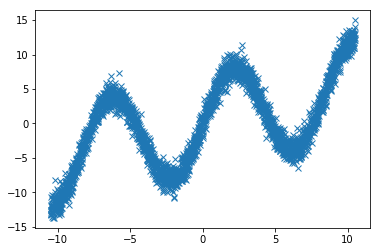

In [3]:
def data_1d(num_samples):
    x = np.float32(np.random.uniform(-10.5, 10.5, (1, num_samples))).T
    r = np.float32(np.random.normal(size=(num_samples, 1)))
    y = np.float32(np.sin(0.75 * x) * 7.0 + x * 0.5 + r * 1.0)
    return {'input': x, 'output': y}

data_dict = data_1d(num_samples)
data_in, data_out = data_dict['input'], data_dict['output']
_ = plt.plot(data_in, data_out, 'x')

And invert it to get a 'multi-valued' function:

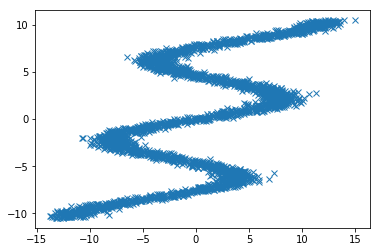

In [4]:
data_in, data_out = data_out, data_in
_ = plt.plot(data_in, data_out, 'x')

<h3> Defining the MDN </h3>

Our MDN module is like a regular fully-connected layer, except it has some special activations. A softmax outputs the mixture components, an exponential activation outputs the $\sigma$'s (ensuring they're positive), and the means $\mu$ have no activations (see equations 25-27 in the paper).

In [5]:
class MixtureDensity(nn.Module):
    def __init__(self, input_dim, output_dim, num_gaussians):
        super(MixtureDensity, self).__init__()
        self.output_dim = (output_dim + 2) * num_gaussians
        self.num_gaussians = num_gaussians
        self.dense = nn.Linear(input_dim, self.output_dim)
        nn.init.xavier_normal(self.dense.weight)

    def forward(self, x):
        x = self.dense(x)
        n_g = self.num_gaussians
        # subtract largest value to help numerical stability
        alpha = F.softmax(x[:, :n_g] - torch.max(x[:, :n_g]), dim=1)
        # add small value also for numerical stability
        sigma = torch.exp(x[:, n_g:2*n_g]) + 0.00001
        mu = x[:, 2*n_g:]
        return {'alpha': alpha, 'sigma': sigma, 'mu': mu}

A mixture density network is a regular neural network (in this case a three layer perceptron) with a final
mixture density output:

In [6]:
class MLP3MDN(nn.Module):
    """A multilayer perceptron with a mixture density output layer."""

    def __init__(self, input_dim, output_dim, num_gaussians,
                 hidden_dims=(128, 128, 128)):
        super(MLP3MDN, self).__init__()
        self.dense1 = nn.Linear(input_dim, hidden_dims[0])
        self.dense2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.dense3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.mdn = MixtureDensity(hidden_dims[2], output_dim, num_gaussians)

        nn.init.xavier_normal(self.dense1.weight)
        nn.init.xavier_normal(self.dense2.weight)
        nn.init.xavier_normal(self.dense3.weight)

    def forward(self, x):
        x = F.relu(self.dense1(x), inplace=True)
        x = F.relu(self.dense2(x), inplace=True)
        x = F.relu(self.dense3(x), inplace=True)
        return self.mdn(x)

<h3> Defining the loss </h3>

What's the loss function for a MDN? As per usual, we try to maximize the likelihood of the data given the model (or equivalently, minimize the negative log-likelihood). In this case the negative log-likelihood of our target data $t$ given our GMM parameters is given by (equation 29 in paper):

$$ loss = \sum_{k=1}^N - ln\big\{\sum_{i=1}^m \alpha_i(x_k)\phi_i(t_k \mid x_k) \big \} $$

This is exactly the function we calculate in the module below. 

<b><i>Exercise:</i></b> These computations can be tricky, verify that the output of the loss module is correct using the pdf available from scipy (see the numpy_loss function below).

In [7]:
class MDNLoss(nn.Module):
    def __init__(self, num_gaussians, output_dim):
        super(MDNLoss, self).__init__()
        self.ng = num_gaussians
        self.c = output_dim
        self.norm_constant = 1.0 / np.power(2*np.pi, self.c/2.0)

    def forward(self, dist_params, targets):
        # extract parameters and prepare for computation
        alpha, sigma, mu = dist_params['alpha'], dist_params['sigma'], dist_params['mu']
        mu = mu.contiguous()
        reshape_mu = mu.view(-1, self.ng, self.c)
        reshape_t = targets.repeat(1, self.ng).view(-1, self.ng, self.c)

        # evaluate multivariate pdf on targets t
        squares = torch.pow(reshape_mu - reshape_t, 2)
        norm_sq = torch.sum(squares, dim=2)
        inv_sigma_sq = 1.0 / (torch.pow(sigma, 2))
        div = -0.5 * norm_sq * inv_sigma_sq
        sigma_pow = torch.pow(sigma, self.c)
        final = torch.exp(div) * self.norm_constant * (1. / sigma_pow)

        # compute neg log loss
        weighted = final * alpha
        prob = torch.sum(weighted, dim=1)
        logprob = -torch.log(prob)
        return torch.mean(logprob)
    

def numpy_loss(t, alpha, sigma, mu):
    from scipy.stats import multivariate_normal
    logprob = []
    for i in range(t.shape[0]):
        prob = 0
        for j in range(config['num gaussians']):
            mean = mu[i, j]
            cov = np.diag([sigma[i, j] ** 2] * config['output dim'])
            prob += alpha[i, j] * multivariate_normal.pdf(t[i], mean=mean, cov=cov)
        logprob.append(np.log(prob))
    return -np.mean(np.array(logprob))

<h3> Training </h3>

Finally we combine all the pieces into a typical training loop and plot the training curve. (We will not focus on finding the optimal network/hyperparameters as this isn't the purpose of this post).

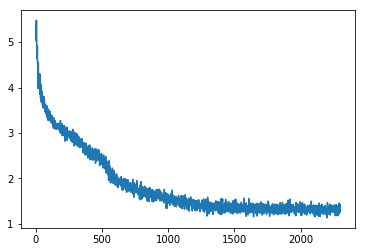

In [8]:
net = MLP3MDN(input_dim=1, output_dim=output_dim,
              num_gaussians=num_gaussians)
net.train()
loss_module = MDNLoss(num_gaussians, output_dim)
optimizer = Adam(net.parameters(), lr=0.0001)

loss_list = []

def train(net, loss_module, optimizer, num_epochs, loss_list):
    for epoch in range(num_epochs):
        p = np.random.permutation(len(data_in))
        inp, out = data_in[p], data_out[p]

        for batch in range(len(data_in) // batchsize):
            index = batch*batchsize
            batch_inputs = inp[index:index + batchsize]
            batch_targets = out[index:index + batchsize]

            optimizer.zero_grad()
            pred = net(Variable(torch.from_numpy(batch_inputs)))
            loss = loss_module(pred, Variable(torch.from_numpy(batch_targets)))
            loss.backward()
            optimizer.step()
            loss_list.append(loss.data[0])

train(net, loss_module, optimizer, num_epochs, loss_list)
_ = plt.plot(loss_list)

To see what the network has learnt, we can't directly look at the output values of the network - rather, we have to sample from the distribution that those outputs define. We can approximate this distribution by sampling from the likeliest component given the input $x$. So the steps are: (1) get the distribution parameters for each value of x, (2) pick a mixture component to sample a target from according to the $\alpha$ distribution, and (3) sample a target from that component:

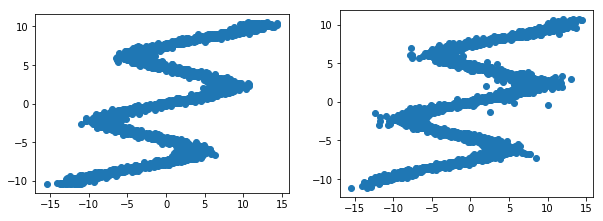

In [9]:
def sample_model(net, data_in, num_gaussians, output_dim):
    params = net(Variable(torch.from_numpy(data_in)))
    alpha = params['alpha'].data.numpy()
    sigma = params['sigma'].data.numpy()
    mu = params['mu'].data.numpy()

    samples = np.zeros((num_samples, output_dim))

    for i in range(num_samples):
        alpha_idx = np.random.choice(num_gaussians, size=1, p=alpha[i])[0]
        s_sigma = sigma[i, alpha_idx]
        mu_idx = alpha_idx * output_dim
        s_mu = mu[i, mu_idx:mu_idx + output_dim]
        cov = np.diag([s_sigma ** 2] * output_dim)
        samples[i, :] = np.random.multivariate_normal(s_mu, cov)
    return samples

# create a new test set and invert it
data_dict = data_1d(num_samples)
data_in, data_out = data_dict['input'], data_dict['output']
data_in, data_out = data_out, data_in

samples = sample_model(net, data_in, num_gaussians, output_dim)

plt.figure(figsize=(10, 10))
plt.subplot(121, adjustable='box', aspect=1)
_ = plt.plot(data_in, data_out, "o")
plt.subplot(122, adjustable='box', aspect=1)
_ = plt.plot(data_in, samples, "o")

<h3> A 2D example </h3>

Let's also do this on a 2D example, to show that it works in more than one dimension. Again, this is the inverse kinematics example from the paper:

In [10]:
num_samples = 5000
L1, L2 = 0.8, 0.2
num_epochs = 200
num_gaussians = 2
input_dim, output_dim = 2, 2

def data_2d(num_samples):
    theta1 = np.float32(np.random.uniform(0.3, 1.2, (num_samples, 1)))
    theta2 = np.float32(np.random.uniform(np.pi / 2, 3 * np.pi / 2, (num_samples, 1)))
    joint_data = np.concatenate([theta1, theta2], axis=1)
    x1 = np.float32(L1 * np.cos(theta1) - L2 * np.cos(theta1 + theta2))
    x2 = np.float32(L1 * np.sin(theta1) - L2 * np.sin(theta1 + theta2))
    end_data = np.concatenate([x1, x2], axis=1)
    return {'input': joint_data, 'output': end_data}

data_dict = data_2d(num_samples)
data_in, data_out = data_dict['input'], data_dict['output']
data_in, data_out = data_out, data_in

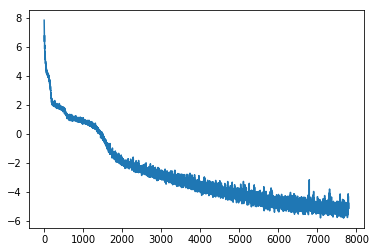

In [11]:
net = MLP3MDN(input_dim=input_dim, output_dim=output_dim,
              num_gaussians=num_gaussians)
net.train()
loss_module = MDNLoss(num_gaussians, output_dim)
optimizer = Adam(net.parameters(), lr=0.0001)

loss_list = []
train(net, loss_module, optimizer, num_epochs, loss_list)
_ = plt.plot(loss_list)

Now we create a test dataset and check our model performance. Since it's harder to visualize in more than one-dimension, we will look at the RMS error of the model and plot the error vectors (similar to Figure 15 in the paper). The model predicts the joints of the robot, so we apply the forward mapping to get the end-effector position and then compare that with the original ground truth.

RMSE:  0.0002907644


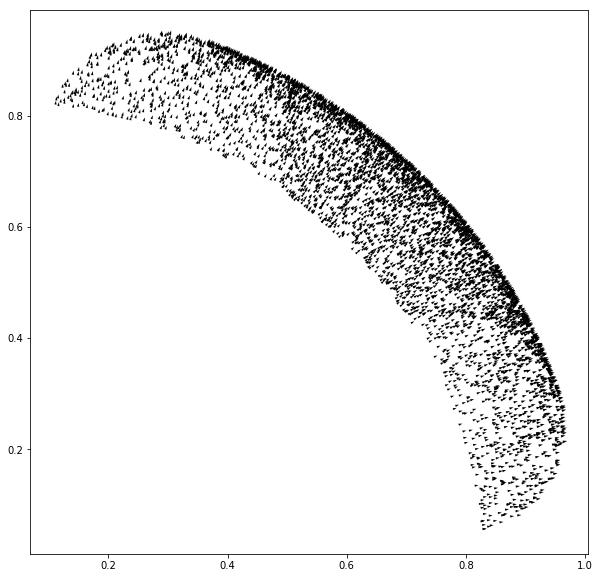

In [12]:
data_dict = data_2d(num_samples)
data_in, data_out = data_dict['input'], data_dict['output']
data_in, data_out = data_out, data_in

model_joint = sample_model(net, data_in, num_gaussians, output_dim)
theta1, theta2 = model_joint[:, 0], model_joint[:, 1]

# compute the forward mapping to compute rmse
x1 = np.float32(L1 * np.cos(theta1) - L2 * np.cos(theta1 + theta2))
x2 = np.float32(L1 * np.sin(theta1) - L2 * np.sin(theta1 + theta2))
pred = np.vstack([x1, x2]).T

from sklearn.metrics import mean_squared_error as MSE
print("RMSE: ", MSE(data_in, pred))

errors = data_in  - pred
vectors = np.concatenate([data_in, pred + errors], axis=1)
X, Y, U, V = zip(*vectors)

plt.figure(figsize=(10, 10))
_ = plt.quiver(X, Y, U, V)

<h3> Conclusion </h3>

We have briefly looked at the theory behind Mixture Density networks and gone through their implementation in pytorch on some simple examples. GMMs are powerful and have many interesting properties. The ideas in this paper are also used in modern deep learning research in generative models, some of which we'll explore in future posts!

<h5> References </h5>

[1] Bishop, C. M. (1994). Mixture density networks.

[2] http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/ 